In [ ]:
%matplotlib inline

In [ ]:
!pip install torch metrics
!pip install 'eugene-tools'

In [45]:
# General imports sourced from how to import data set jores github
import os
import sys
import numpy as np
import pandas as pd

# EUGENe imports
import eugene as eu
from eugene import dataload as dl
from eugene import preprocess as pp
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/"

# EUGENe packages
import seqdatasets
import seqdata as sd

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqDatasets version: {seqdatasets.__version__}")
print(f"SeqData version: {sd.__version__}")

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
NumPy version: 1.23.5
Pandas version: 1.5.3
Eugene version: 0.1.2
SeqDatasets version: 0.1.2
SeqData version: 0.1.3


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')
cwd = os.getcwd()
print(cwd)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

In [46]:
class DNASequenceDataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.data = self.file['sequences']
        self.labels = self.file['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

NameError: name 'Dataset' is not defined

In [ ]:
# Check the dataset
seqdatasets.get_dataset_info()

,n_seqs,n_targets,metadata,url,description,author
dataset_name,,,,,,
random1000,1000,1,10 randomly generated binary labels (label_{0-...,https://github.com/cartercompbio/EUGENe/tree/m...,A randomly generated set of 1000 sequences wit...,Adam Klie (aklie@eng.ucsd.edu)
ray13,241357,244,"probe set (Probe_Set), bidning intensity value...",http://hugheslab.ccbr.utoronto.ca/supplementar...,This dataset represents an in vitro RNA bindin...,Hayden Stites (haydencooperstites@gmail.com)
farley15,163708,2,"barcode (Barcode), RPMs from each biological r...",https://zenodo.org/record/6863861#.YuG15uxKg-Q,This dataset represents SEL-seq data of C. int...,Adam Klie (aklie@eng.ucsd.edu)
deBoer20,100000000+,1,Variable depending on chosen file,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Gigantic parallel reporter assay data from ~10...,Adam Klie (aklie@eng.ucsd.edu)
jores21,147966,1,"set (set), species (sp), gene promoter came fr...",https://raw.githubusercontent.com/tobjores/Syn...,"This datast includes activity scores for 79,83...",Adam Klie (aklie@eng.ucsd.edu)
deAlmeida22,484052,4,Normalized enrichment scores for developmental...,https://zenodo.org/record/5502060/,This dataset includes UMI-STARR-seq data from ...,Adam Klie (aklie@eng.ucsd.edu)


In [ ]:
# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

In [ ]:
from eugene import plot as pl
from eugene import preprocess as pp


In [ ]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

In [ ]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

In [ ]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

In [ ]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

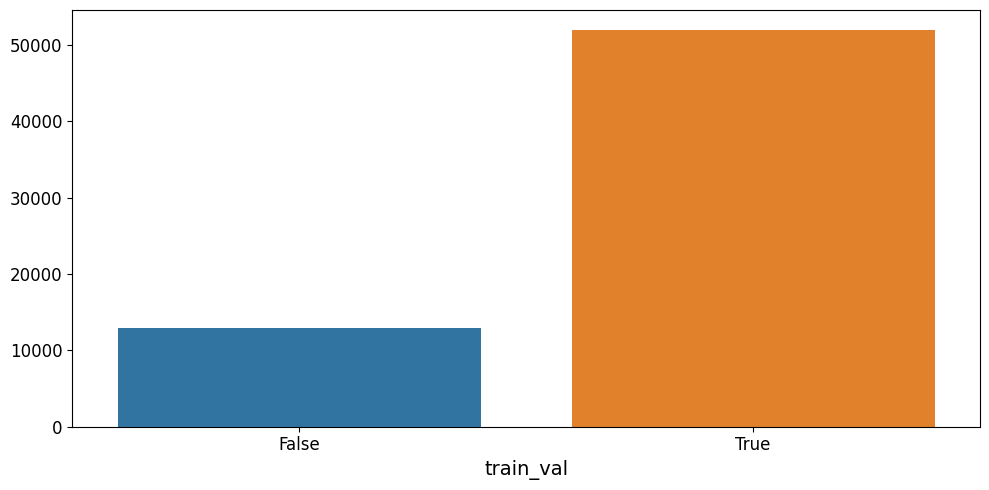

In [ ]:
# Check the split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")

In [ ]:
from eugene import models
from eugene.models import zoo
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
!pip install evoaug
!pip install git+https://github.com/p-koo/evoaug_analysis.git

  Preparing metadata (setup.py) ... done
  Created wheel for evoaug: filename=evoaug-1.0.6-py3-none-any.whl size=6380 sha256=6f550058b7427de2f99e68522cc1555e51323fd6e51355a866bf3711e09c7fe7
  Stored in directory: /root/.cache/pip/wheels/df/b3/68/1da7b54f77edaff05a9ab9dfb5a71dc827ee9d02cbee279d01
Successfully built evoaug
  Cloning https://github.com/p-koo/evoaug_analysis.git to /tmp/pip-req-build-allanxuw
  Running command git clone --filter=blob:none --quiet https://github.com/p-koo/evoaug_analysis.git /tmp/pip-req-build-allanxuw
  Resolved https://github.com/p-koo/evoaug_analysis.git to commit 74d798097305338b6dec8c6842a0cfc6f53a8624
  Preparing metadata (setup.py) ... done
  Created wheel for evoaug_analysis: filename=evoaug_analysis-0.1.0-py3-none-any.whl size=8210 sha256=cba2eb613a61afbd0ce4789bb87dbb08fd57e1dc4d54bda7c65e6fc1baa07362
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzrw2qhf/wheels/04/33/2d/65190d63a1b8d5fde393e172329d0fe1a81844527f442d5a84
Successfully built evo

In [ ]:
from eugene.models.base import _layers as layers
from eugene.models.base import _blocks as blocks
from eugene.models.base import _towers as towers
from eugene.models.zoo._basic_models import FCN, CNN, RNN, Hybrid
from eugene import train
#model parts and important imports like train

In [ ]:
#Define X as a random tensor of the correct shape
x = torch.randn(1, 4, 100)

In [ ]:
#customized CNN model with input length of
model = CNN(
    input_len=100,
    output_dim=10,
    conv_kwargs={
        "input_channels": 4,
        "conv_channels": [10, 10],
        "conv_kernels": [5, 3],
        "activations": "relu",
        "pool_types": "max"
    }
)
model_out = model(x)
model, model_out.shape


(CNN(
   (conv1d_tower): Conv1DTower(
     (layers): Sequential(
       (0): Conv1d(4, 10, kernel_size=(5,), stride=(1,), padding=valid)
       (1): ReLU()
       (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
       (3): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=valid)
       (4): ReLU()
       (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
     )
   )
   (dense_block): DenseBlock(
     (layers): Sequential(
       (0): Linear(in_features=940, out_features=10, bias=True)
     )
   )
 ),
 torch.Size([1, 10]))

In [ ]:
# Initialize the weights
models.init_weights(model)

In [47]:

# You could imagine building this a ton of different ways, but here is a simple example
import torch.nn.functional as F
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()

        # Set the attributes
        self.input_len = 100
        self.output_dim = 1

        # Create the blocks
        self.conv1 = nn.Conv1d(4, 30, 21)
        self.relu  = nn.ReLU()

        self.dense = nn.Linear(30, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = F.max_pool1d(x, x.size()[-1]).flatten(1, -1)
        x = self.dense(x)
        return x

In [48]:

# Now we can pass this to the module
models.SequenceModule(
    arch=SmallCNN(),
    task="binary_classification",
    loss_fxn="bce",
    optimizer="adam",
    metric="auroc",
    metric_kwargs={"task": "binary"}
)

ValueError: Unexpected keyword arguments: `num_outputs`

In [40]:
# Initialize the model
model = CNNModule(
    input_len=170,
    output_dim=1,
    conv_kwargs={
        "input_channels": 4,
        "conv_channels": [10, 10],
        "conv_kernels": [5, 3],
        "activations": "relu",
        "pool_types": "max"
    }
)

In [43]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=2,
    prefetch_factor=2,
    drop_last=False,
    name="hybrid",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


AttributeError: 'CNNModule' object has no attribute 'scheduler'